## Spectral Code for Incompressible MHD Simulation
### Prototype Study for HD 

For NS equation without the magnetic field, we can write it as:  
$$\frac{\partial{\bf u}}{\partial t} + {\bf u}\cdot \nabla u= -\nabla P - \upsilon \nabla^2 {\bf u} + {\bf f}$$
We can always do the fourier transform and see how can we solve it using spectral method. So, the result would be:  

$$ \frac{\partial{\bf u_k}}{\partial t}  + F({\bf u}\cdot \nabla u) = -{\bf k}P_k - \upsilon {\bf k^2} {\bf u_k} + {\bf f_k} $$

we have one more condition to reach, which is 
$$\nabla \cdot {\bf }v = 0$$

In [1]:
#Loading the main Package
using FFTW
#using DifferentialEquations
using PyPlot
using PyCall
np = pyimport("numpy")

PyObject <module 'numpy' from '/home/doraho/.julia/conda/3/lib/python3.7/site-packages/numpy/__init__.py'>

In [11]:
#Reference: NS2D.jl
N = 256;



ux = Array{ComplexF32, 2}(undef, N, N);
uy = Array{ComplexF32, 2}(undef, N, N);
∂ux∂x = Array{ComplexF32, 2}(undef, N, N);
∂uy∂y = Array{ComplexF32, 2}(undef, N, N);
ω  = Array{ComplexF32, 2}(undef, N, N);

nx,ny = size(ux);
Lx,Ly = 1,1;

#Setup the wavenumber
kx = fftfreq(nx, nx/Lx) * 2π;
ky = fftfreq(ny, ny/Ly) * 2π;



# julia implementation of 
#https://en.wikibooks.org/wiki/Parallel_Spectral_Numerical_Methods/The_Two-_and_Three-Dimensional_Navier-Stokes_Equations

In [2]:
function ic(N::Number)
    h = 1.0/(N);
    x = [h*i for i =1:N];
    y = [h*i for i =1:N];
    
    xx,yy = zeros(N,N),zeros(N,N);
    for j in 1:N, i in 1:N
        xx[i,j] = x[i];
        yy[i,j] = y[j];
    end
    
    u=zeros((N,N))
    v=zeros((N,N))
    u_y=zeros((N,N))
    v_x=zeros((N,N))
    ω=zeros((N,N))
    
    # Initial conditions
    for j in 1:size(y)[1], i in 1:size(y)[1]
        u[i,j] = sin(2π*x[i])*cos(2π*y[j]);
        v[i,j] = -cos(2π*x[i])*sin(2π*y[j]);
        u_y[i,j] = -2π*sin(2π*x[i])*sin(2π*y[j]);
        v_x[i,j] = 2π*sin(2π*x[i])*sin(2π*y[j]);
        ω[i,j]   = v_x[i,j]-u_y[i,j];
    end

    #Setup the wavenumber
    k_x = 2π*fftfreq(N, N)*im;#nx,nx
    k_y = 2π*fftfreq(N, N)*im;#ny,ny
    kx = zeros(ComplexF32,N,N)
    ky = zeros(ComplexF32,N,N)
    kxx = zeros(ComplexF32,N,N)
    kyy = zeros(ComplexF32,N,N)

    for j in 1:N, i in 1:N
        kx[i,j] = k_x[i];
        ky[i,j] = k_y[j];
        kxx[i,j] = k_x[i]^2;
        kyy[i,j] = k_y[j]^2;
    end

    ψ_hat = zeros(ComplexF32,N,N);
    ω_hat = zeros(ComplexF32,N,N);
    ω_hatold = zeros(ComplexF32,N,N);
    nl_hat = zeros(ComplexF32,N,N);
    nl_hatold = zeros(ComplexF32,N,N);
    dψx = zeros(Float32,N,N)
    dψy = zeros(Float32,N,N)
    ω_check = zeros(Float32,N,N)
    ω_old = zeros(Float32,N,N)
    
    #preform calcuation
    ω_hat = fft(ω);
    nl_hat = fft(u.*ifft(ω_hat.*kx) + v.*ifft(ω_hat.*ky));
    
    return u,v,u_y,v_x,
            ω,ω_check,ω_hat,ω_hatold,
            nl_hat,nl_hatold,
            ψ_hat,dψx,dψy,
            kx,ky,kxx,kyy;
end

ic (generic function with 1 method)

In [13]:
function evolution(u,v,u_y,v_x,
            ω,ω_check,ω_old,ω_hat,ω_hatold,
            nl_hat,nl_hatold,
            ψ_hat,dψx,dψy,
            kx,ky,kxx,kyy;t_end=0.10,dt=0.0025)
    # Looping until reaching the target time
    N  = size(u)[1];
    tol=1e-10;
    temp = Array{Float32, 2}(undef, N, N);
    
    t=0.0; 
    Rey = 1;
    xx,yy = zeros(N,N),zeros(N,N);
    h = 1.0/(N-1);
    x = [h*i for i =1:N];
    y = [h*i for i =1:N];
    
    for j in 1:N, i in 1:N
        xx[i,j] = x[i];
        yy[i,j] = y[j];
    end
    
    
    while (t<=t_end)
        chg   = 1.0;
        ω_check=copy(ω);
        ω_hatold = copy(ω_hat);
        nl_hatold = copy(nl_hat);

        while (chg>tol)
            nl_hat = fft(u.*ifft(ω_hat.*kx)+v.*ifft(ω_hat.*ky));
            ω_hat  = @. ((1/dt + 0.5*(1/Rey)*(kxx+kyy))*ω_hatold -
                0.5*(nl_hatold+nl_hat))/(1/dt -0.5*(1/Rey)*(kxx+kyy));
            ψ_hat  = @. -ω_hat/(kxx+kyy);
            ψ_hat[1,1] = 0;
            ψ_hat[div(N,2)+1,div(N,2)+1] = 0;
            ψ_hat[div(N,2)+1,1] = 0;
            ψ_hat[1,div(N,2)+1] = 0;
            
            dψx = real(ifft(ψ_hat.*kx));
            dψy = real(ifft(ψ_hat.*ky));
            u   = dψy;
            v   = -1.0*dψx;

            ω = real(ifft(ω_hat));
            chg = maximum(abs.(ω-ω_check));
            ω_check = ω;
            #figure()
            #imshow(ω); 
        end
        t+=dt;
        uexact_y=-2*pi*sin.(2*pi.*xx).*sin.(2*pi.*yy).*exp(-8*pi^2*t/Rey);
        vexact_x=2*pi*sin.(2*pi.*xx).*sin.(2*pi.*yy).*exp(-8*pi^2*t/Rey);
        omegaexact=vexact_x-uexact_y;
        figure()
        subplot(131); imshow(ω); 
        subplot(132); imshow(omegaexact);
        subplot(133); imshow(ω-omegaexact); 
    end
    return u,v,u_y,v_x,
            ω,ω_check,ω_hat,ω_hatold,
            nl_hat,nl_hatold,
            ψ_hat,dψx,dψy,
            kx,ky,kxx,kyy;
end

evolution (generic function with 1 method)

In [43]:
function isolated_vortex(x, y ; x₀=0.0, y₀=0.0, Γ=1.0, r=1.0)

    # --> Center the mesh around the (x₀, y₀) position.
    Lx = maximum(abs.(x))
    Ly = maximum(abs.(y))
    x, y = collect(x .- x₀), collect(y .- y₀)

    # --> Enforce periodicity.
    x[x .> Lx] .= x[x .> Lx] .- 2Lx
    x[x .< -Lx] .= x[x .< -Lx] .+ 2Lx

    y[y .> Ly] .= y[y .> Ly] .- 2Ly
    y[y .< -Ly] .= y[y .< -Ly] .+ 2Ly

    # --> Isolated vortex vorticity field.
    r² = (x').^2 .+ y.^2
    ω = Γ/(π*r^2) .* exp.(-r²./r^2)

    # --> Map to spectral space.
    ω = fft(ω)

    return ω
end


function compute_velocity(ω,Lx,Ly,nx,ny)

    # --> Get the wavenumbers.
    α = fftfreq(nx, nx/Lx) * 2π
    β = fftfreq(ny, ny/Ly) * 2π

    # --> Initialize arrays.
    vx, vy = zero(ω), zero(ω)

    # --> Compute the velocity component in spectral space.
    for j = 1:nx, i = 1:ny

        # --> Streamfunction.
        k² = α[j]^2 + β[i]^2
        ψ = i == j == 1 ? zero(ω[i, j]) : ω[i, j] / k²

        # --> Velocity.
        vx[i, j] = im * β[i] * ψ
        vy[i, j] = im * α[j] * ψ

    end
    
    # --> From spectral space to physical space.
    ifft!(vx), ifft!(vy)

    return real(vx), real(vy)
end

function compute_gradient(v,dx;direction=1)
    if direction == 1
        dv = circshift(v,(1,0))-circshift(v,(-1,0));
    elseif direction ==2
        dv = circshift(v,(0,1))-circshift(v,(0,-1)); 
    end
    return dv./dx/2
end

function ic_isolated_vortex(N::Number)
    h = 1.0/(N);
    x = [h*i for i =1:N];
    y = [h*i for i =1:N];
    
    xx,yy = zeros(N,N),zeros(N,N);
    for j in 1:N, i in 1:N
        xx[i,j] = x[i];
        yy[i,j] = y[j];
    end
    # Initial conditions
    dx = abs(x[end]-x[end-1]);
    ω = isolated_vortex(xx, yy ; x₀=0.0, y₀=0.0, Γ=1.0, r=1.0);
    u,v = compute_velocity(ω,x[end],y[end],N,N);
    u_y = compute_gradient(u,dx;direction=2);
    v_x = compute_gradient(u,dx;direction=2);

    #Setup the wavenumber
    k_x = 2π*fftfreq(N, N)*im;#nx,nx
    k_y = 2π*fftfreq(N, N)*im;#ny,ny
    kx = zeros(ComplexF32,N,N)
    ky = zeros(ComplexF32,N,N)
    kxx = zeros(ComplexF32,N,N)
    kyy = zeros(ComplexF32,N,N)

    for j in 1:N, i in 1:N
        kx[i,j] = k_x[i];
        ky[i,j] = k_y[j];
        kxx[i,j] = k_x[i]^2;
        kyy[i,j] = k_y[j]^2;
    end

    ψ_hat = zeros(ComplexF32,N,N);
    ω_hat = zeros(ComplexF32,N,N);
    ω_hatold = zeros(ComplexF32,N,N);
    nl_hat = zeros(ComplexF32,N,N);
    nl_hatold = zeros(ComplexF32,N,N);
    dψx = zeros(Float32,N,N)
    dψy = zeros(Float32,N,N)
    ω_check = zeros(Float32,N,N)
    ω_old = zeros(Float32,N,N)
    
    #preform calcuation
    ω_hat = fft(ω);
    nl_hat = fft(u.*ifft(ω_hat.*kx) + v.*ifft(ω_hat.*ky));
    
    return u,v,u_y,v_x,
            ω,ω_check,ω_old,ω_hat,ω_hatold,
            nl_hat,nl_hatold,
            ψ_hat,dψx,dψy,
            kx,ky,kxx,kyy;
end



ic_isolated_vortex (generic function with 1 method)

In [58]:
N =256
h = 1.0/(N);
x = [h*i for i =1:N];
y = [h*i for i =1:N];

xx,yy = zeros(N,N),zeros(N,N);
for j in 1:N, i in 1:N
    xx[i,j] = x[i];
    yy[i,j] = y[j];
end
# Initial conditions
dx = abs(x[end]-x[end-1]);
ω = isolated_vortex(xx, yy ; x₀=0.0, y₀=0.0, Γ=1.0, r=1.0);
u,v = compute_velocity(ω,x[end],y[end],N,N);
u_y = compute_gradient(u,dx;direction=2);
v_x = compute_gradient(u,dx;direction=2);

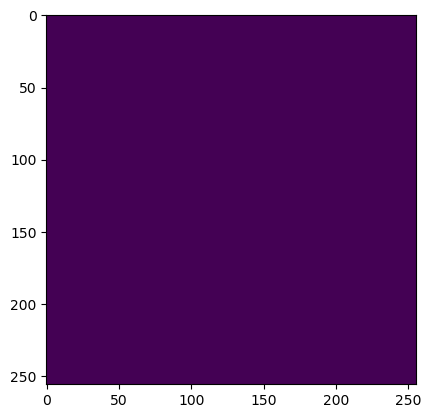

PyObject <matplotlib.image.AxesImage object at 0x7f19d1fe31d0>

In [67]:
imshow(v_x)

In [46]:
imshow(ω)

LoadError: PyError ($(Expr(:escape, :(ccall(#= /home/doraho/.julia/packages/PyCall/tqyST/src/pyfncall.jl:43 =# @pysym(:PyObject_Call), PyPtr, (PyPtr, PyPtr, PyPtr), o, pyargsptr, kw))))) <class 'TypeError'>
TypeError('Image data of dtype complex128 cannot be converted to float')
  File "/home/doraho/.julia/conda/3/lib/python3.7/site-packages/matplotlib/pyplot.py", line 2683, in imshow
    None else {}), **kwargs)
  File "/home/doraho/.julia/conda/3/lib/python3.7/site-packages/matplotlib/__init__.py", line 1601, in inner
    return func(ax, *map(sanitize_sequence, args), **kwargs)
  File "/home/doraho/.julia/conda/3/lib/python3.7/site-packages/matplotlib/cbook/deprecation.py", line 369, in wrapper
    return func(*args, **kwargs)
  File "/home/doraho/.julia/conda/3/lib/python3.7/site-packages/matplotlib/cbook/deprecation.py", line 369, in wrapper
    return func(*args, **kwargs)
  File "/home/doraho/.julia/conda/3/lib/python3.7/site-packages/matplotlib/axes/_axes.py", line 5671, in imshow
    im.set_data(X)
  File "/home/doraho/.julia/conda/3/lib/python3.7/site-packages/matplotlib/image.py", line 685, in set_data
    "float".format(self._A.dtype))


In [41]:
gg

([0.00390625 0.00390625 … 0.00390625 0.00390625; 0.0078125 0.0078125 … 0.0078125 0.0078125; … ; 0.99609375 0.99609375 … 0.99609375 0.99609375; 1.0 1.0 … 1.0 1.0], var"#57#58"())

In [14]:
x = [h*i for i =1:N];
y = [h*i for i =1:N];

LoadError: UndefVarError: h not defined

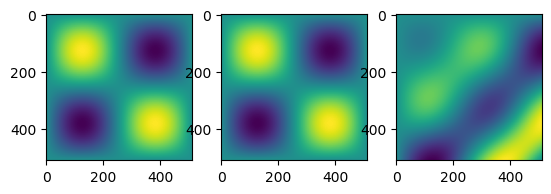

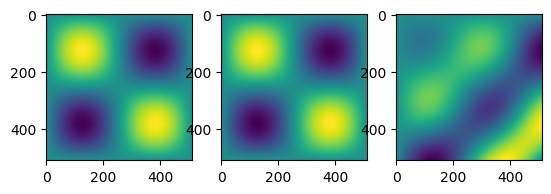

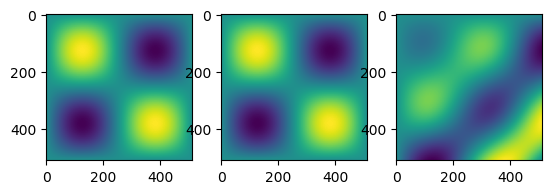

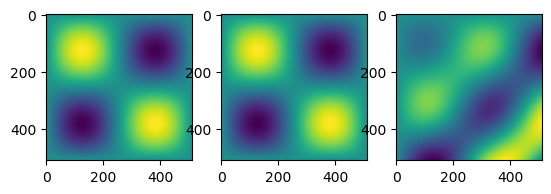

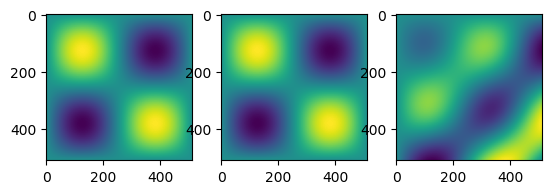

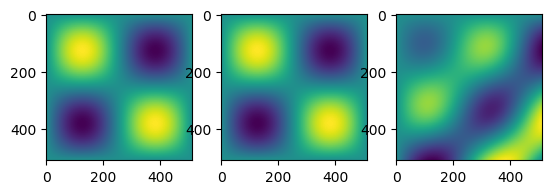

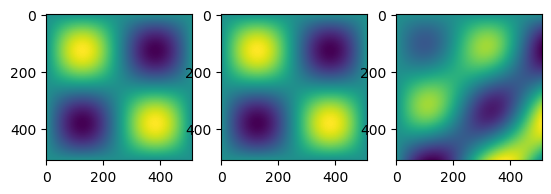

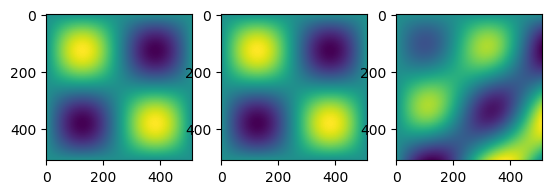

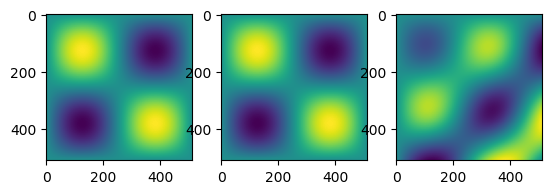

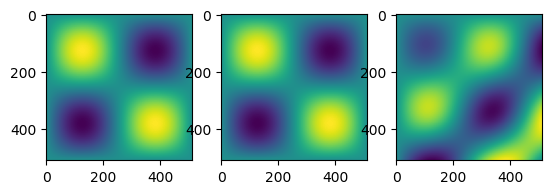

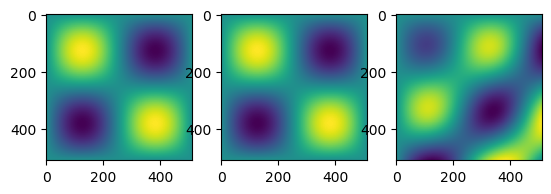

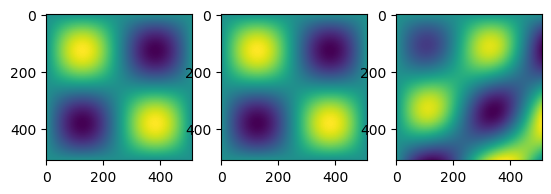

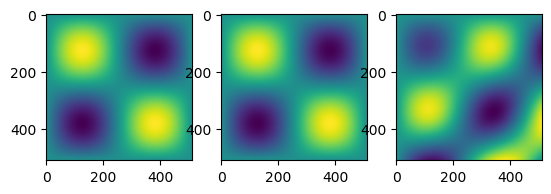

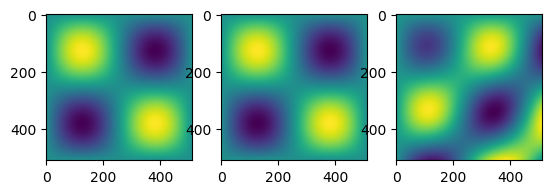

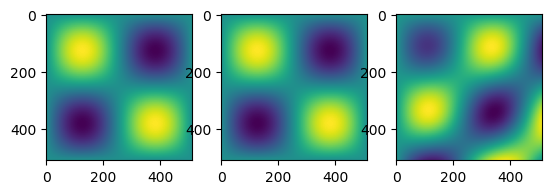

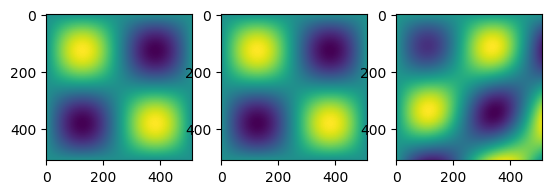

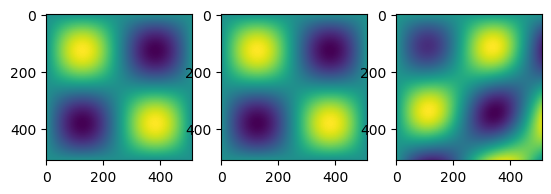

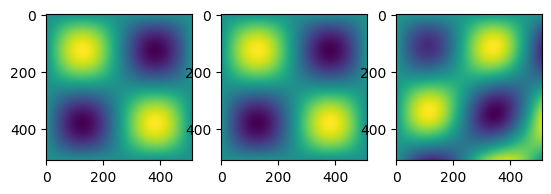

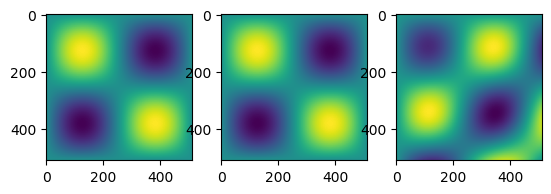

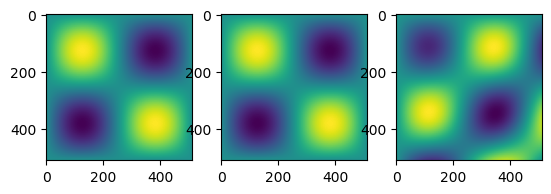

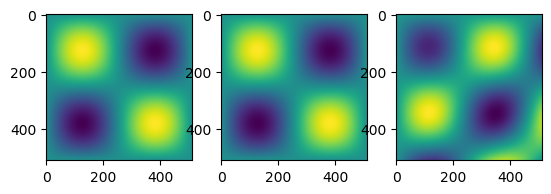

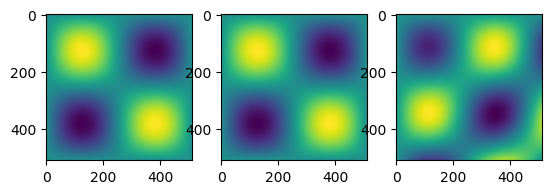

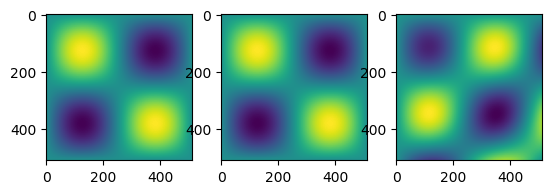

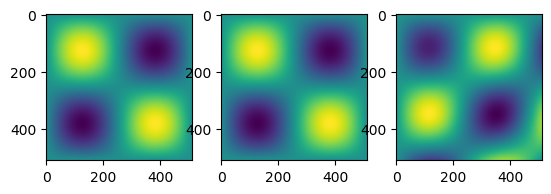

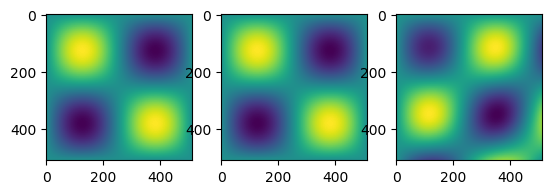

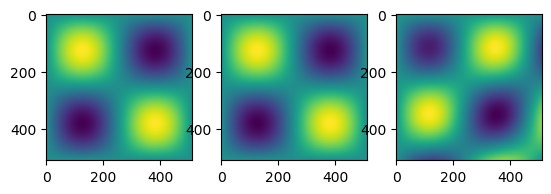

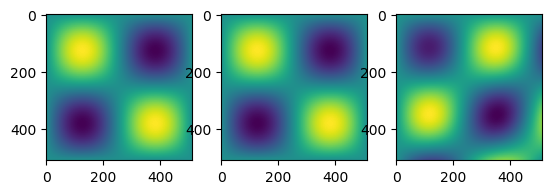

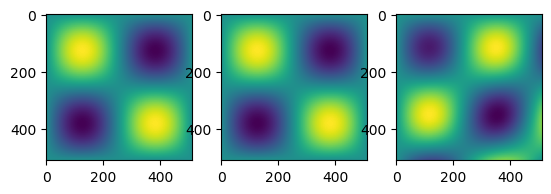

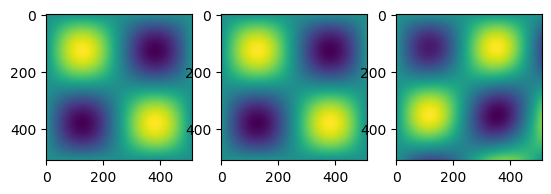

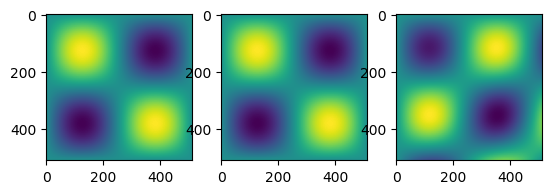

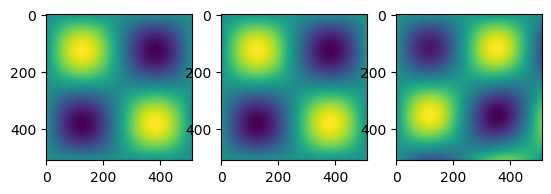

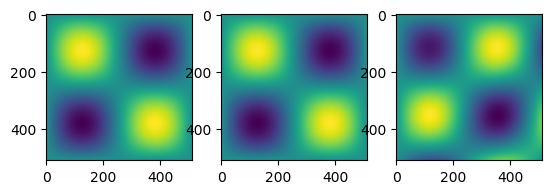

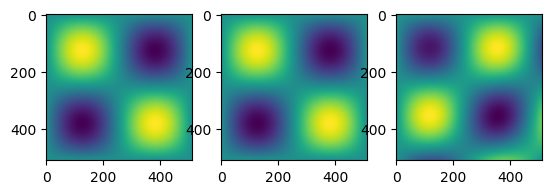

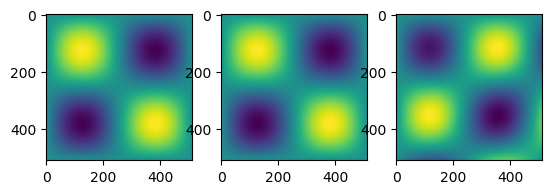

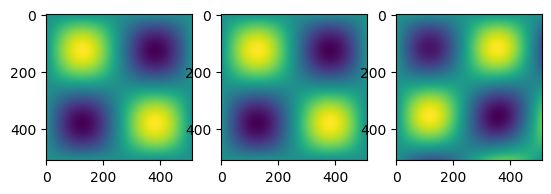

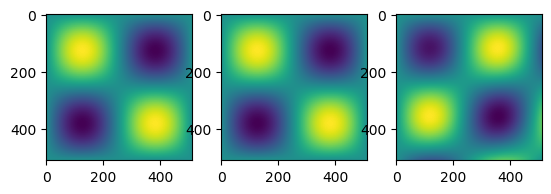

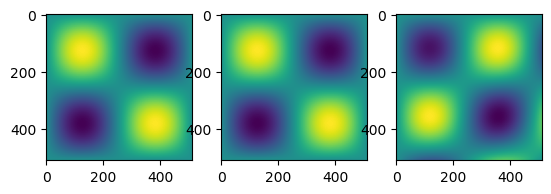

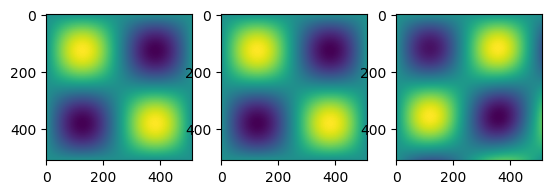

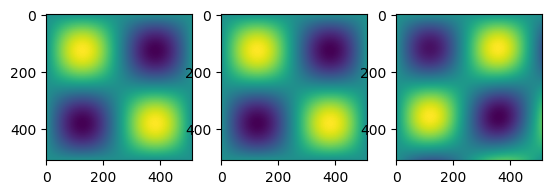

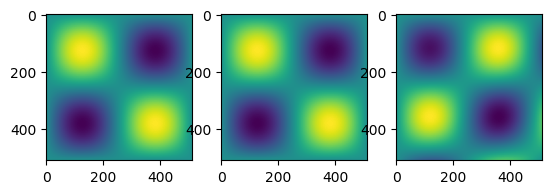

([4.4526144340782125e-6 4.451608587796966e-6 … 4.452614434076815e-6 4.452949733003047e-6; 8.904558320799891e-6 8.902546779714335e-6 … 8.904558320798468e-6 8.905228868155266e-6; … ; -4.452614434076827e-6 -4.451608587795906e-6 … -4.452614434078179e-6 -4.4529497330026004e-6; 6.767577721420866e-19 5.100164358537728e-19 … -6.987276711590116e-19 2.1072634961548494e-19], [-4.452614434077349e-6 -8.904558320799032e-6 … 4.452614434077623e-6 1.0842021724855044e-19; -4.451608587796286e-6 -8.90254677971365e-6 … 4.451608587796574e-6 1.6263032587282567e-19; … ; -4.452614434077338e-6 -8.904558320798998e-6 … 4.452614434077623e-6 8.131516293641283e-20; -4.452949733002678e-6 -8.905228868154888e-6 … 4.452949733002966e-6 1.3552527156068805e-19], [-0.0009461889714034177 -0.0018922354502280987 … 0.0009461889714034676 1.8885118853699483e-17; -0.0018922354502280984 -0.003784185936757582 … 0.0018922354502281984 3.776739367796452e-17; … ; 0.0009461889714034676 0.0018922354502281986 … -0.0009461889714035175 -1.88

In [14]:
N = 512
u,v,u_y,v_x,ω,ω_check,ω_old,ω_hat,ω_hatold,nl_hat,nl_hatold,ψ_hat,dψx,dψy,kx,ky,kxx,kyy=ic(N);

evolution(u,v,u_y,v_x,
        ω,ω_check,ω_old,ω_hat,ω_hatold,
        nl_hat,nl_hatold,
        ψ_hat,dψx,dψy,
        kx,ky,kxx,kyy;t_end=0.10,dt=0.0025)

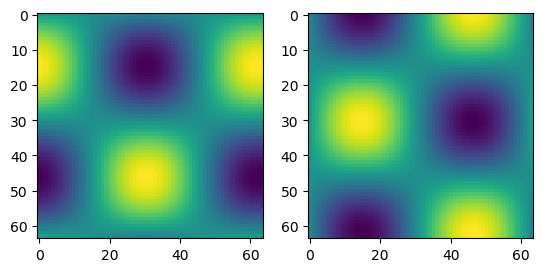

PyObject <matplotlib.image.AxesImage object at 0x7fdff7054550>

In [26]:
figure()
subplot(121)
imshow(u)
subplot(122)
imshow(v)

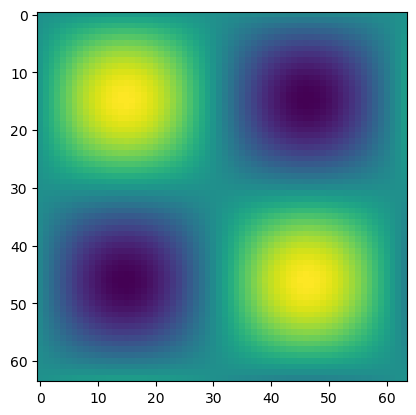

PyObject <matplotlib.image.AxesImage object at 0x7fdff6e9de48>

In [27]:
imshow(ω)

In [28]:
dt     = 0.00025;
Rey    = 1
nl_hat = fft(u.*ifft(ω_hat.*kx)+v.*ifft(ω_hat.*kx));
ω_hat  = @. ((1/dt + 0.5*(1/Rey)*(kxx+kyy))*ω_hatold - 0.5*(nl_hatold+nl_hat))/(1/dt -0.5*(1/Rey)*(kxx+kyy));
ψ_hat  = @. -ω_hat/(kxx+kyy);
ψ_hat[1,1] = 0;
ψ_hat[div(N,2)+1,div(N,2)+1] = 0;
ψ_hat[div(N,2)+1,1] = 0;
ψ_hat[1,div(N,2)+1] = 0;
ψ_hat[isnan.(ψ_hat)].=0;

In [29]:
kxx

64×64 Array{Complex{Float32},2}:
      0.0+0.0im       0.0+0.0im  …       0.0+0.0im       0.0+0.0im
 -39.4784+0.0im  -39.4784+0.0im     -39.4784+0.0im  -39.4784+0.0im
 -157.914+0.0im  -157.914+0.0im     -157.914+0.0im  -157.914+0.0im
 -355.306+0.0im  -355.306+0.0im     -355.306+0.0im  -355.306+0.0im
 -631.655+0.0im  -631.655+0.0im     -631.655+0.0im  -631.655+0.0im
  -986.96+0.0im   -986.96+0.0im  …   -986.96+0.0im   -986.96+0.0im
 -1421.22+0.0im  -1421.22+0.0im     -1421.22+0.0im  -1421.22+0.0im
 -1934.44+0.0im  -1934.44+0.0im     -1934.44+0.0im  -1934.44+0.0im
 -2526.62+0.0im  -2526.62+0.0im     -2526.62+0.0im  -2526.62+0.0im
 -3197.75+0.0im  -3197.75+0.0im     -3197.75+0.0im  -3197.75+0.0im
 -3947.84+0.0im  -3947.84+0.0im  …  -3947.84+0.0im  -3947.84+0.0im
 -4776.89+0.0im  -4776.89+0.0im     -4776.89+0.0im  -4776.89+0.0im
 -5684.89+0.0im  -5684.89+0.0im     -5684.89+0.0im  -5684.89+0.0im
         ⋮                       ⋱                  
 -5684.89+0.0im  -5684.89+0.0im     -5684.8

In [30]:
A = @. 1/(1/dt -0.5*(1/Rey)*(kxx+kyy));
(kxx.+kyy)[findall(isnan.(A))]

Complex{Float32}[]

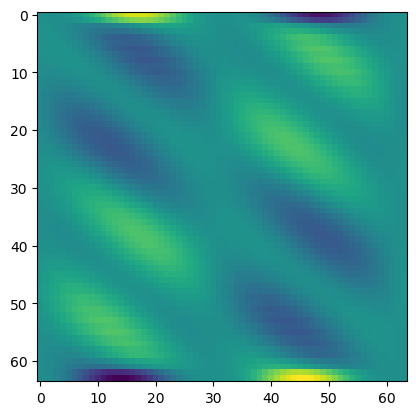

In [31]:
nl_hat = fft(u.*ifft(ω_hat.*kx)+v.*ifft(ω_hat.*kx));
ω_hat  = @. ((1/dt + 0.5*(1/Rey)*(kxx+kyy))*ω_hatold - 0.5*(nl_hatold+nl_hat))/(1/dt -0.5*(1/Rey)*(kxx+kyy));
ψ_hat  = @. -ω_hat/(kxx+kyy);
ψ_hat[1,1] = 0;
ψ_hat[div(N,2)+1,div(N,2)+1] = 0;
ψ_hat[div(N,2)+1,1] = 0;
ψ_hat[1,div(N,2)+1] = 0;
ψ_hat[isnan.(ψ_hat)].=0;
dψx = real(ifft(ψ_hat.*kx));
dψy = real(ifft(ψ_hat.*ky));
u   = dψx;
v   = -1.0*dψy;
ω_hat[isnan.(ω_hat)].=0
ω = real(ifft(ω_hat));
chg = maximum(abs.(ω-ω_check));
ω_check = ω;
figure()
imshow(ω); 

In [49]:
N = 64
u,v,u_y,v_x,ω,ω_check,ω_old,ω_hat,ω_hatold,nl_hat,nl_hatold,ψ_hat,dψx,dψy,kx,ky,kxx,kyy=ic(N);

In [60]:
nlhat

64×64 Array{Complex{Float32},2}:
 0.0+0.0im  0.0+0.0im  0.0+0.0im  …  0.0+0.0im  0.0+0.0im  0.0+0.0im
 0.0+0.0im  0.0+0.0im  0.0+0.0im     0.0+0.0im  0.0+0.0im  0.0+0.0im
 0.0+0.0im  0.0+0.0im  0.0+0.0im     0.0+0.0im  0.0+0.0im  0.0+0.0im
 0.0+0.0im  0.0+0.0im  0.0+0.0im     0.0+0.0im  0.0+0.0im  0.0+0.0im
 0.0+0.0im  0.0+0.0im  0.0+0.0im     0.0+0.0im  0.0+0.0im  0.0+0.0im
 0.0+0.0im  0.0+0.0im  0.0+0.0im  …  0.0+0.0im  0.0+0.0im  0.0+0.0im
 0.0+0.0im  0.0+0.0im  0.0+0.0im     0.0+0.0im  0.0+0.0im  0.0+0.0im
 0.0+0.0im  0.0+0.0im  0.0+0.0im     0.0+0.0im  0.0+0.0im  0.0+0.0im
 0.0+0.0im  0.0+0.0im  0.0+0.0im     0.0+0.0im  0.0+0.0im  0.0+0.0im
 0.0+0.0im  0.0+0.0im  0.0+0.0im     0.0+0.0im  0.0+0.0im  0.0+0.0im
 0.0+0.0im  0.0+0.0im  0.0+0.0im  …  0.0+0.0im  0.0+0.0im  0.0+0.0im
 0.0+0.0im  0.0+0.0im  0.0+0.0im     0.0+0.0im  0.0+0.0im  0.0+0.0im
 0.0+0.0im  0.0+0.0im  0.0+0.0im     0.0+0.0im  0.0+0.0im  0.0+0.0im
    ⋮                             ⋱                        
 0.0+0.0im

In [96]:
N =64
#Setup the wavenumber
k_x = 2π*fftfreq(N, N)*im;#nx,nx
k_y = 2π*fftfreq(N, N)*im;#ny,ny

In [101]:
kxx

512×512 Array{Complex{Float32},2}:
      0.0+0.0im       0.0+0.0im  …       0.0+0.0im       0.0+0.0im
 -39.4784+0.0im  -39.4784+0.0im     -39.4784+0.0im  -39.4784+0.0im
 -157.914+0.0im  -157.914+0.0im     -157.914+0.0im  -157.914+0.0im
 -355.306+0.0im  -355.306+0.0im     -355.306+0.0im  -355.306+0.0im
 -631.655+0.0im  -631.655+0.0im     -631.655+0.0im  -631.655+0.0im
  -986.96+0.0im   -986.96+0.0im  …   -986.96+0.0im   -986.96+0.0im
 -1421.22+0.0im  -1421.22+0.0im     -1421.22+0.0im  -1421.22+0.0im
 -1934.44+0.0im  -1934.44+0.0im     -1934.44+0.0im  -1934.44+0.0im
 -2526.62+0.0im  -2526.62+0.0im     -2526.62+0.0im  -2526.62+0.0im
 -3197.75+0.0im  -3197.75+0.0im     -3197.75+0.0im  -3197.75+0.0im
 -3947.84+0.0im  -3947.84+0.0im  …  -3947.84+0.0im  -3947.84+0.0im
 -4776.89+0.0im  -4776.89+0.0im     -4776.89+0.0im  -4776.89+0.0im
 -5684.89+0.0im  -5684.89+0.0im     -5684.89+0.0im  -5684.89+0.0im
         ⋮                       ⋱          ⋮       
 -5684.89+0.0im  -5684.89+0.0im  …  -5684